# 1D Kalman filter

Example here is an object moving in 1D. We sample position with noise, and want to know velocity. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy.linalg import inv
import scipy.integrate as spi 

g = 9.81


# Data generation
We'll generate this in advance and just sample. 

In [2]:
dt = 0.1
n_meas = 300

if False:
    time = np.arange(0, n_meas)*dt
    velocity = np.ones_like(time)*60
    pos = spi.cumtrapz(velocity, dx=dt, initial=0)

else:
    time = np.arange(0, n_meas)*dt
    velocity = np.cos(2*np.pi*time/50)*60
    pos = spi.cumtrapz(velocity, dx=dt, initial=0)

def gen_noisy_pos(sample_number):

    v = 8 * np.random.randn(1, 1)

    return dt, pos[sample_number]+v



In [3]:


class kalman():

    def __init__(self, meas_fcn):
         
        self.samplesTaken = 0
        self.meas_fcn = meas_fcn

    def getMeasurement(self):

        self.dt, self.z = self.meas_fcn(self.samplesTaken)      
        self.samplesTaken += 1
        
    
    def filter(self):
        # Initialize State

        if self.samplesTaken == 1:
            # n = 2  [length of state vector]
            # m = 1  [length of measurement vector]
            
            # n x 1
            self.x = np.array([[0],     # Where we think we should have started
                               [20]])   # Initial guess of velocity
            
            # n x n
            self.P = np.array([[5, 0],  # aposteriori estimate of the covariance
                               [0, 5]]) 
            
            # n x n
            self.A = np.array([[1, dt], # State transition matrix - i.e. physical model
                                [0, 1]])
            
            # m x n
            self.H = np.array([[1, 0]]) # State to measurement operator
                                        #       excluding the measurement noise part
            # n x m
            self.HT = np.array([[1],    
                                [0]])
            
            # m x m
            self.R = np.array([10])     # Measurement noise covariance matrix 
            
            # n x n
            self.Q = np.array([[1, 0],  # Physical model covariance matrix 
                               [0, 3]])
            
        ######################################################
        ## Forecast step
        ## Apriori estimate from your model and previous state
        ######################################################

        # Use model and last state to estimate next state
        x_p = self.A.dot(self.x)
        
        # Predict Covariance Forward
        # Use model and last cov matrix to estimate next cov matrix
        P_p = self.A.dot(self.P).dot(self.A.T) + self.Q
        
        ####################################################
        ## Analysis step
        ## Measurement update step
        ## Measurement update equations
        ####################################################

        # Compute Kalman Gain
        S = self.H.dot(P_p).dot(self.HT) + self.R
        # K = P_p.dot(self.HT)*(1/S)
        K = P_p.dot(self.HT)@inv(S)
        
        # Calculate innovation
        observable_part_of_prior = self.H.dot(x_p)   
        residual = self.z - observable_part_of_prior # d, observational increment, innovation

        # Estimate state
        self.x   = x_p + K*residual

        # Estimate Covariance
        # Update covariance for the next step
        self.P = P_p - K.dot(self.H).dot(P_p)
        
        # return [self.x[0], self.x[1], self.P]

In [4]:
def testFilter(meas_fcn, n_meas):
    
    t = np.linspace(0, 10, num=n_meas)
    
    mykalman = kalman(meas_fcn)

    measTime = np.array([])
    measPos = np.array([])
    estPos  = np.array([])
    estVel = np.array([])
    
    posBound3Sigma = []

    for k in range(0, n_meas):

        # New measurement         
        m = mykalman.getMeasurement()

        # Call Filter and return new State
        f = mykalman.filter()
        
        currentPositionEst = mykalman.x[0]
        currentVelocityEst = mykalman.x[1]

        posVar = mykalman.P

        measTime = np.hstack([measTime, np.array(k)])
        measPos = np.hstack([measPos, mykalman.z[:, 0]])
        estPos  = np.hstack([estPos,  currentPositionEst])
        estVel  = np.hstack([estVel,  currentVelocityEst])

        posBound3Sigma.append(3*np.sqrt(posVar[0][0]))
        
        # measDifPos.append(mykalman.z        - mykalman.currentPosition)
        # estDifPos.append(currentPositionEst - mykalman.currentPosition)
        
    return [measTime, measPos, estPos, estVel, posBound3Sigma], mykalman

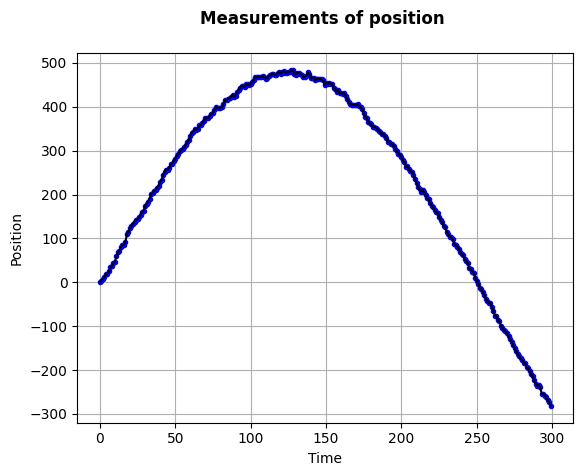

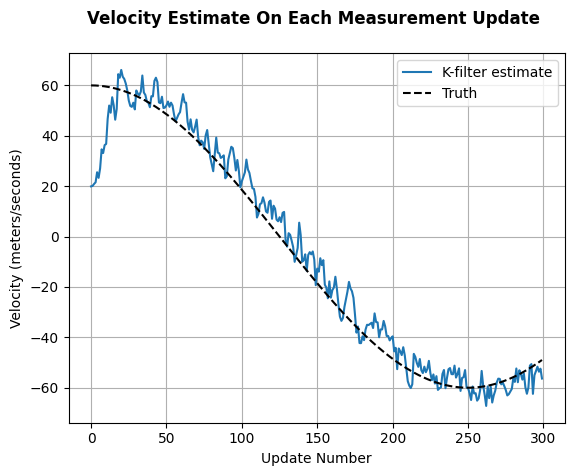

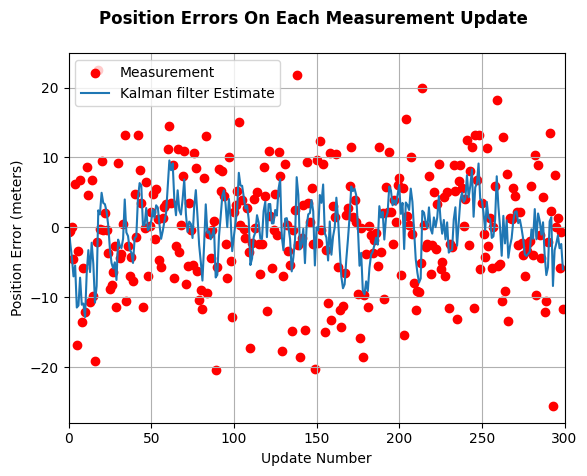

In [5]:
t, mykalman = testFilter(gen_noisy_pos, n_meas)
measTime, measPos, estPos, estVel, posBound3Sigma = t

measDifPos = np.array(measPos) - pos
estDifPos  = np.array(estPos) - pos

plot1 = plt.figure(1)
plt.plot(measTime,    estPos, 'b.')
plt.plot(measTime,    estPos, 'k')
plt.ylabel('Position')
plt.xlabel('Time')
plt.title('Measurements of position \n', fontweight="bold")
plt.grid(True)
plt.show()

plot2 = plt.figure(2)
plt.plot(measTime, estVel, label='K-filter estimate')
plt.plot(measTime, velocity, 'k--', label='Truth')
plt.ylabel('Velocity (meters/seconds)')
plt.xlabel('Update Number')
plt.title('Velocity Estimate On Each Measurement Update \n', fontweight="bold")
plt.legend(['Estimate'])
plt.grid(True)
plt.legend()
plt.show()

plot3 = plt.figure(3)
plt.scatter(measTime, measDifPos, color = 'red')
plt.plot(measTime, estDifPos)
plt.legend(['Measurement', 'Kalman filter Estimate'])
plt.title('Position Errors On Each Measurement Update \n', fontweight="bold")
#plt.plot(t[0], t[6])
plt.ylabel('Position Error (meters)')
plt.xlabel('Update Number')
plt.grid(True)
plt.xlim([0, 300])
plt.show()